## Visual Transformer for Skin Cancer Detection

In [2]:
import evaluate
import torch
from transformers import ViTForImageClassification, Trainer, TrainingArguments
from transformers import ViTImageProcessor
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import datasets
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import h5py
import cv2
from PIL import Image
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import safetensors.torch

2024-10-31 11:34:07.477388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730388847.496956  282034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730388847.503028  282034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 11:34:07.525504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#loading data
BASE_PATH = "isic-2024-challenge"

# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))

# Testing
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

/scratch/291154.1.ood/ipykernel_282034/4180780485.py:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


In [4]:
#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1
neg_sample = .01
pos_sample = 5.0
# Sampling
positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=True, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [5]:
training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

In [6]:
#split into train and validation sets
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True) # ensure continuous index
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4713 | Num Valid: 1259


In [7]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=processor.image_mean, std=processor.image_std),
    ])

def preprocess_images(example):
        byte_string = training_validation_hdf5[example["isic_id"]][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
        image = Image.fromarray(image)
        example['pixel_values'] = transform(image)
        return example



ds_training = datasets.Dataset.from_pandas(pd.DataFrame(data=training_df))
ds_valid = datasets.Dataset.from_pandas(pd.DataFrame(data=validation_df))

ds_training = ds_training.map(preprocess_images, batched=False)
ds_valid = ds_valid.map(preprocess_images, batched=False)

Parameter 'function'=<function preprocess_images at 0x14e4daecf420> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/4713 [00:00<?, ? examples/s]

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

In [8]:
#accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [9]:
#load/preprosses dataset
model_name='google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

#load the model from google
model = ViTForImageClassification.from_pretrained(model_name)

# Make sure its the right tensor types
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(example['pixel_values']) for example in batch])
    labels = torch.tensor([example['target'] for example in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./vit-finetuned-agent0',
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    metric_for_best_model="accuracy",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_training,
    eval_dataset=ds_valid,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/projectnb/cs640grp/students/samwu/AgentO/.venv/lib64/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/291154.1.ood/ipykernel_282034/1110159578.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [11]:
#train da model
trainer.train()

# Save da fine-tuned model
trainer.save_model('./vit-finetuned-agentO')

Epoch,Training Loss,Validation Loss


In [13]:
trainer.eval_dataset=ds_valid
trainer.evaluate()

{'eval_loss': 1.0206170082092285,
 'eval_accuracy': 0.7903097696584591,
 'eval_runtime': 87.456,
 'eval_samples_per_second': 14.396,
 'eval_steps_per_second': 1.807,
 'epoch': 4.0}

In [26]:
ds_valid = datasets.Dataset.from_pandas(pd.DataFrame(data=validation_df))

def process_test_set(ds, num_samples):
    inputs = []
    labels = []
    for i in range(num_samples):
        byte_string = training_validation_hdf5[ds[i]["isic_id"]][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
        image = Image.fromarray(image)
        inputs.append(image)
        labels.append(ds[i]["target"]) 
    return inputs, labels

inputs, y_true = process_test_set(ds_valid, 100)
print(inputs[:10])

[<PIL.Image.Image image mode=RGB size=139x139 at 0x14E4DBB91990>, <PIL.Image.Image image mode=RGB size=129x129 at 0x14E4DF5E8D50>, <PIL.Image.Image image mode=RGB size=127x127 at 0x14E4DAFBD190>, <PIL.Image.Image image mode=RGB size=115x115 at 0x14E4DAF15E50>, <PIL.Image.Image image mode=RGB size=119x119 at 0x14E4DAE17CD0>, <PIL.Image.Image image mode=RGB size=137x137 at 0x14E4DAF01C10>, <PIL.Image.Image image mode=RGB size=137x137 at 0x14E4DAE29610>, <PIL.Image.Image image mode=RGB size=149x149 at 0x14E4DAE2B550>, <PIL.Image.Image image mode=RGB size=111x111 at 0x14E4DAD806D0>, <PIL.Image.Image image mode=RGB size=129x129 at 0x14E4DACD9AD0>]


In [27]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
state_dict = safetensors.torch.load_file("vit-finetuned-agentO/model.safetensors")
model.load_state_dict(state_dict)

image_classifier = pipeline("image-classification", model,image_processor=processor)
predictions = image_classifier(inputs)
#select highest labels
predictions = [max(item, key=lambda x: x['score'])['label'] for item in predictions]
#convert from LABEL_0, LABEL_1 to 0,1
predictions = [1 if item == 'LABEL_1' else 0 for item in predictions]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


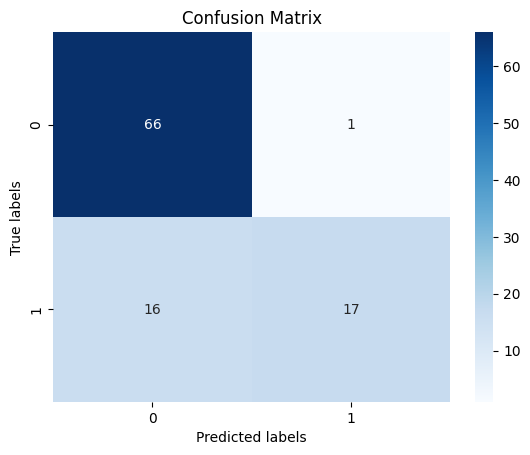

In [29]:
#plot confusion matrix
confusion_metric = evaluate.load("confusion_matrix")
confusion_matrix = confusion_metric.compute(predictions=predictions, references=y_true)
matrix = confusion_matrix['confusion_matrix']
if 'labels' in confusion_matrix:
    labels = confusion_matrix['labels']
else:
    labels = np.unique(predictions + y_true)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()